In [0]:
import os
import torch
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary
import timeit
import random
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from sklearn import preprocessing
height = 480
width = 640

'''Creates Random tensor that is the same size as the image (for testing)'''
def imageBatch(nb_image):
    imgBatch = torch.rand(nb_image, 3, width, height)
    return imgBatch

'''Creates Random tensor that is the same size as the depthmap (for testing)'''
def depthBatch(nb_image):
    depthBatch = torch.rand(nb_image, width*height, 1, 1)
    return depthBatch

def normalize(imageBatch):
    for i in range(len(imageBatch)):
      imageBatch[i] = preprocessing.normalize(imageBatch[i], norm='l2', axis=1, copy=True, return_norm=False)
    return imageBatch

'''CNN doing the first stage of the Semi-Siamese Network (forms the two 'heads')'''
def firstStageCNN():
    return nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, stride=2),  # optional: add stride
                         nn.ReLU(inplace=True),
                         nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1),

                         nn.Conv2d(32, 62, kernel_size=3, stride=2),
                         nn.ReLU(inplace=True),
                         nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1),
                         nn.MaxPool2d(kernel_size=3),  # optional: add stride
                         nn.ReLU(inplace=True),

                         nn.Conv2d(62, 92, kernel_size=3, stride=2),  # optional: add stride
                         nn.ReLU(inplace=True),
                         nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1),

                         nn.MaxPool2d(kernel_size=3),  # optional: add stride
                         nn.ReLU(inplace=True))

'''Form the complete network by taking the two heads and connecting them to
the body'''
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = firstStageCNN()

        self.cnn2 = firstStageCNN()

        self.fc = nn.Sequential(nn.Conv2d(8832, 92, kernel_size=1),
                                nn.ReLU(inplace=True),

                                nn.Upsample(scale_factor=2, mode='nearest'),
                                nn.ReLU(inplace=True),

                                nn.Conv2d(92, 62, kernel_size=1),
                                nn.ReLU(inplace=True),

                                nn.Upsample(scale_factor=2, mode='nearest'),
                                nn.ReLU(inplace=True),

                                nn.Conv2d(62, 32, kernel_size=4),
                                nn.ReLU(inplace=True),

                                nn.Conv2d(32, width*height, kernel_size=1),
                                nn.ReLU(inplace=True)
                                )

    '''forwards through the first CNNs to the Main body then returns the output'''
    def forward(self, input1, input2):
        output1 = self.cnn1(input1)
        output2 = self.cnn2(input2)

        combined = torch.cat((output1.view(output1.size(0), -1),
                              output2.view(output2.size(0), -1)), dim=1)

        combined = torch.unsqueeze(combined, 2)
        combined = torch.unsqueeze(combined, 3)
        out = self.fc(combined)
        return out

''' Does the training of the whole dataset'''
def train(net, training_DATA_LEFT, training_DATA_RIGHT, depthMaps, EPOCHS, BATCH_SIZE):
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    loss_function = nn.MSELoss()
    dataset = utils.TensorDataset(training_DATA_LEFT, training_DATA_RIGHT, depthMaps)
    train_dataloader = DataLoader(dataset, shuffle=True, num_workers=0, batch_size=1)
    net.zero_grad()
    COUNTER = 0
    print("train function was executed")
    for epoch in range(EPOCHS):
        for i, data in enumerate(train_dataloader):

            img1, img2, depthmap = data
            optimizer.zero_grad() # reset gradient
            outputs = net(img1, img2)
            loss = loss_function(outputs, depthmap)
            print("Loss:", loss)

            loss.backward()
            optimizer.step()
        #Print out images and epoch numbers 
        print("Epoch number: ", COUNTER)
        COUNTER += 1 
        print("Loss:", loss)
        plt.figure()
        plt.imshow((outputs.view(height,width)).detach().numpy())
        # plt.show()
        plt.figure()
        plt.imshow((depthmap.view(height,width)).detach().numpy())
        # plt.show
        image = img1.view(3,480,640)
        plt.figure()
        plt.imshow(np.swapaxes(np.swapaxes(image.detach().numpy(),0,2),0,1))
        plt.show()
        outputs = net(img1, img2)
        img1 = img1.view(3,480,640)
        plt.figure()
        plt.imshow((outputs.view(height,width)).detach().numpy())
        plt.figure()
        plt.imshow((depthmap.view(height,width)).detach().numpy())
        plt.figure()
        plt.imshow(np.swapaxes(np.swapaxes(img1.detach().numpy(),0,2),0,1))
        plt.show()
    return net


train function was executed
Loss: tensor(32350.6172, grad_fn=<MseLossBackward>)
Loss: tensor(49993.8906, grad_fn=<MseLossBackward>)
Loss: tensor(138841.1094, grad_fn=<MseLossBackward>)
Loss: tensor(47375.3086, grad_fn=<MseLossBackward>)
Loss: tensor(95614.6719, grad_fn=<MseLossBackward>)
Loss: tensor(102668.8672, grad_fn=<MseLossBackward>)
Loss: tensor(32117.2539, grad_fn=<MseLossBackward>)
Loss: tensor(217766.4375, grad_fn=<MseLossBackward>)
Loss: tensor(303682.3125, grad_fn=<MseLossBackward>)
Loss: tensor(90045.8125, grad_fn=<MseLossBackward>)
Loss: tensor(133217.4844, grad_fn=<MseLossBackward>)
Loss: tensor(27169.0410, grad_fn=<MseLossBackward>)
Loss: tensor(26724.1641, grad_fn=<MseLossBackward>)
Loss: tensor(42508.5000, grad_fn=<MseLossBackward>)
Loss: tensor(113115.2109, grad_fn=<MseLossBackward>)
Loss: tensor(54170.9102, grad_fn=<MseLossBackward>)
Loss: tensor(42472.1602, grad_fn=<MseLossBackward>)
Loss: tensor(29093.6230, grad_fn=<MseLossBackward>)
Loss: tensor(154198.4844, grad

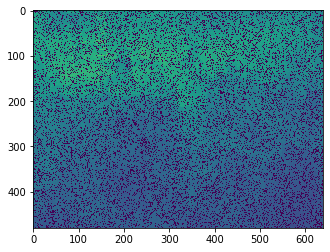

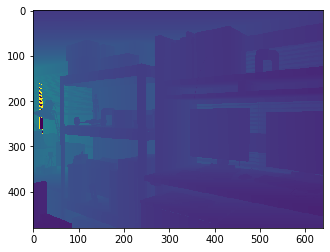

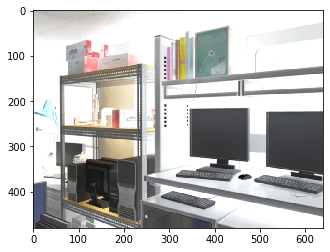

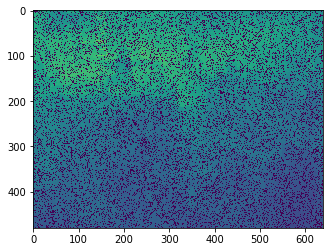

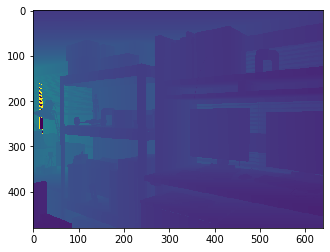

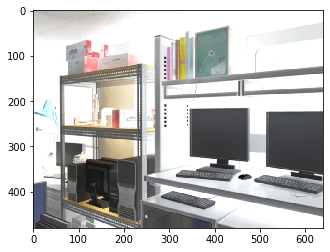

Loss: tensor(58479.2656, grad_fn=<MseLossBackward>)
Loss: tensor(28722.0938, grad_fn=<MseLossBackward>)
Loss: tensor(34774.0664, grad_fn=<MseLossBackward>)
Loss: tensor(13091.6240, grad_fn=<MseLossBackward>)
Loss: tensor(27557.4648, grad_fn=<MseLossBackward>)
Loss: tensor(23999.1621, grad_fn=<MseLossBackward>)
Loss: tensor(24683.0859, grad_fn=<MseLossBackward>)
Loss: tensor(15760.5977, grad_fn=<MseLossBackward>)
Loss: tensor(160211.5625, grad_fn=<MseLossBackward>)
Loss: tensor(178412.0469, grad_fn=<MseLossBackward>)
Loss: tensor(207222.3125, grad_fn=<MseLossBackward>)
Loss: tensor(61496.3789, grad_fn=<MseLossBackward>)
Loss: tensor(14726.8945, grad_fn=<MseLossBackward>)
Loss: tensor(62252.8828, grad_fn=<MseLossBackward>)
Loss: tensor(12503.1602, grad_fn=<MseLossBackward>)
Loss: tensor(11876.9209, grad_fn=<MseLossBackward>)
Loss: tensor(13280.2891, grad_fn=<MseLossBackward>)
Loss: tensor(21871.0605, grad_fn=<MseLossBackward>)
Loss: tensor(56836.4531, grad_fn=<MseLossBackward>)
Loss: ten

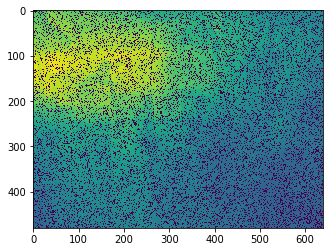

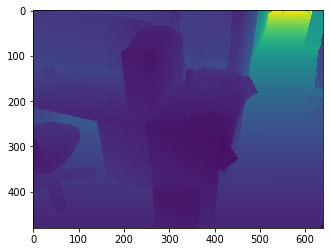

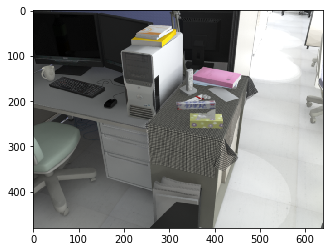

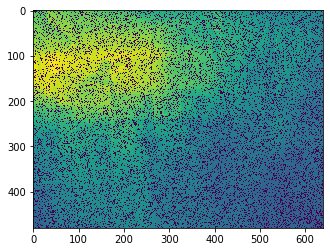

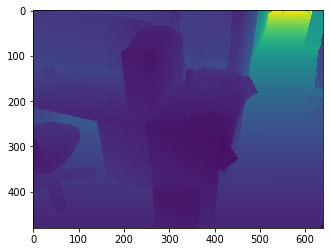

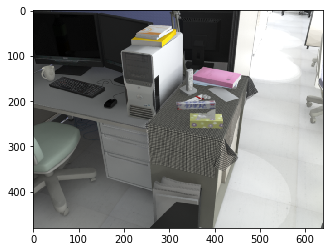

Loss: tensor(39659.7227, grad_fn=<MseLossBackward>)
Loss: tensor(13338.8838, grad_fn=<MseLossBackward>)
Loss: tensor(43548.6797, grad_fn=<MseLossBackward>)
Loss: tensor(10924.8389, grad_fn=<MseLossBackward>)
Loss: tensor(70514.5547, grad_fn=<MseLossBackward>)
Loss: tensor(13019.1143, grad_fn=<MseLossBackward>)
Loss: tensor(11992.9375, grad_fn=<MseLossBackward>)
Loss: tensor(109748.8828, grad_fn=<MseLossBackward>)
Loss: tensor(7246.2769, grad_fn=<MseLossBackward>)
Loss: tensor(12000.5840, grad_fn=<MseLossBackward>)
Loss: tensor(12312.6465, grad_fn=<MseLossBackward>)
Loss: tensor(38186.2383, grad_fn=<MseLossBackward>)
Loss: tensor(32092.1934, grad_fn=<MseLossBackward>)
Loss: tensor(91552.7266, grad_fn=<MseLossBackward>)
Loss: tensor(122285.8047, grad_fn=<MseLossBackward>)
Loss: tensor(61520.0508, grad_fn=<MseLossBackward>)
Loss: tensor(77664.6953, grad_fn=<MseLossBackward>)
Loss: tensor(47254.8047, grad_fn=<MseLossBackward>)
Loss: tensor(56922.6484, grad_fn=<MseLossBackward>)
Loss: tenso

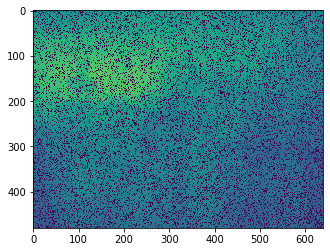

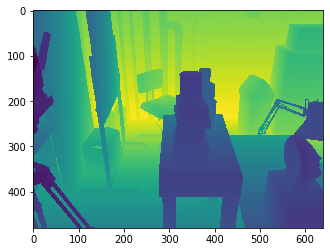

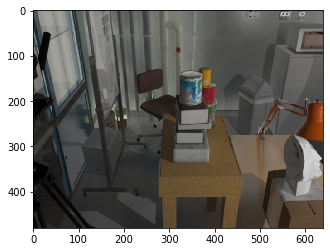

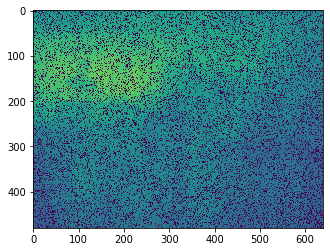

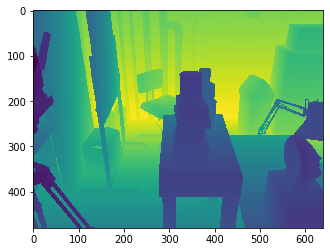

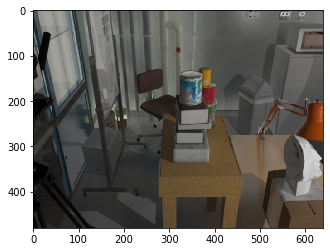

Loss: tensor(32309.8105, grad_fn=<MseLossBackward>)
Loss: tensor(97229.1484, grad_fn=<MseLossBackward>)
Loss: tensor(27321.9707, grad_fn=<MseLossBackward>)
Loss: tensor(45078.8320, grad_fn=<MseLossBackward>)
Loss: tensor(60211.4297, grad_fn=<MseLossBackward>)
Loss: tensor(44493.0625, grad_fn=<MseLossBackward>)
Loss: tensor(44411.9375, grad_fn=<MseLossBackward>)
Loss: tensor(10269.1113, grad_fn=<MseLossBackward>)
Loss: tensor(137351.9219, grad_fn=<MseLossBackward>)
Loss: tensor(26446.9883, grad_fn=<MseLossBackward>)
Loss: tensor(38961.0156, grad_fn=<MseLossBackward>)
Loss: tensor(13920.3281, grad_fn=<MseLossBackward>)
Loss: tensor(17468.7793, grad_fn=<MseLossBackward>)
Loss: tensor(34190.5820, grad_fn=<MseLossBackward>)
Loss: tensor(36585.3750, grad_fn=<MseLossBackward>)
Loss: tensor(47360.3945, grad_fn=<MseLossBackward>)
Loss: tensor(13169.2920, grad_fn=<MseLossBackward>)
Loss: tensor(51658.8281, grad_fn=<MseLossBackward>)
Loss: tensor(14086.4248, grad_fn=<MseLossBackward>)
Loss: tenso

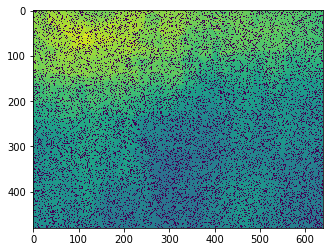

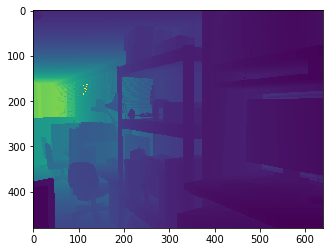

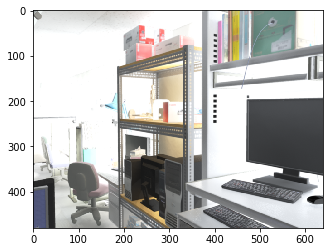

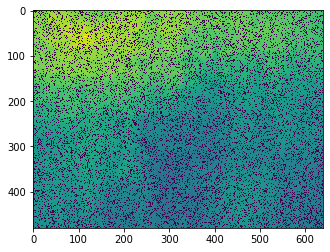

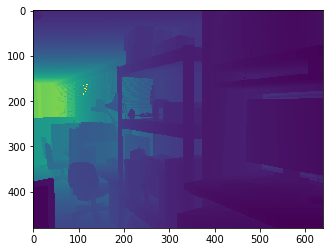

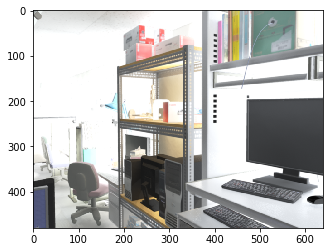

Loss: tensor(43619.4727, grad_fn=<MseLossBackward>)
Loss: tensor(32183.4219, grad_fn=<MseLossBackward>)
Loss: tensor(10938.2588, grad_fn=<MseLossBackward>)
Loss: tensor(19684.8789, grad_fn=<MseLossBackward>)
Loss: tensor(11227.0068, grad_fn=<MseLossBackward>)
Loss: tensor(62427.9609, grad_fn=<MseLossBackward>)
Loss: tensor(6478.1416, grad_fn=<MseLossBackward>)
Loss: tensor(56181.8281, grad_fn=<MseLossBackward>)
Loss: tensor(55940.6953, grad_fn=<MseLossBackward>)
Loss: tensor(120437.8281, grad_fn=<MseLossBackward>)
Loss: tensor(54500.4258, grad_fn=<MseLossBackward>)
Loss: tensor(30888.1152, grad_fn=<MseLossBackward>)
Loss: tensor(35920.5469, grad_fn=<MseLossBackward>)
Loss: tensor(96258.5469, grad_fn=<MseLossBackward>)
Loss: tensor(48030.4062, grad_fn=<MseLossBackward>)
Loss: tensor(92567.1875, grad_fn=<MseLossBackward>)
Loss: tensor(18733.9121, grad_fn=<MseLossBackward>)
Loss: tensor(80795.2344, grad_fn=<MseLossBackward>)
Loss: tensor(21917.4668, grad_fn=<MseLossBackward>)
Loss: tensor

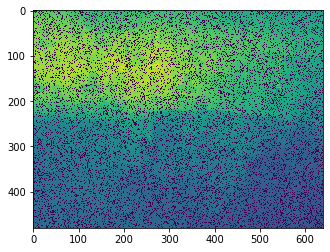

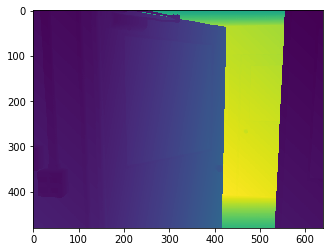

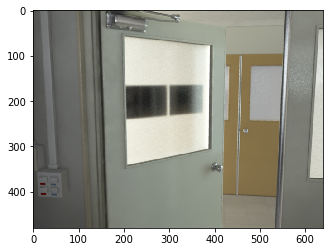

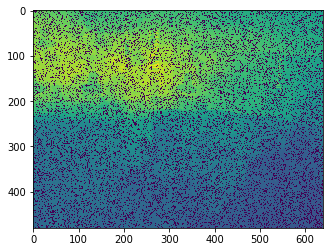

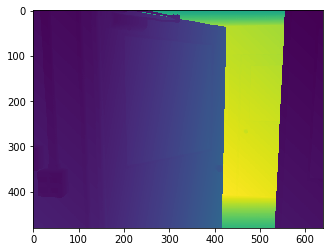

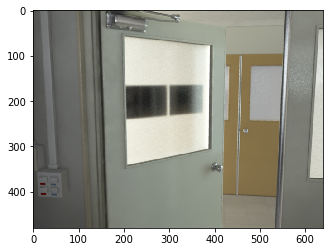

Loss: tensor(37062.3984, grad_fn=<MseLossBackward>)
Loss: tensor(7140.3379, grad_fn=<MseLossBackward>)
Loss: tensor(38531.9961, grad_fn=<MseLossBackward>)
Loss: tensor(12136.3291, grad_fn=<MseLossBackward>)
Loss: tensor(48255.2578, grad_fn=<MseLossBackward>)
Loss: tensor(58456.1250, grad_fn=<MseLossBackward>)
Loss: tensor(87065.4297, grad_fn=<MseLossBackward>)
Loss: tensor(78349.9062, grad_fn=<MseLossBackward>)
Loss: tensor(86983.6016, grad_fn=<MseLossBackward>)
Loss: tensor(36896.3359, grad_fn=<MseLossBackward>)
Loss: tensor(65288.3281, grad_fn=<MseLossBackward>)
Loss: tensor(59991.7812, grad_fn=<MseLossBackward>)
Loss: tensor(47379.0430, grad_fn=<MseLossBackward>)
Loss: tensor(16466.6016, grad_fn=<MseLossBackward>)
Loss: tensor(17776.4863, grad_fn=<MseLossBackward>)
Loss: tensor(32415.1387, grad_fn=<MseLossBackward>)
Loss: tensor(70614.8516, grad_fn=<MseLossBackward>)
Loss: tensor(63890.3242, grad_fn=<MseLossBackward>)
Loss: tensor(124343.7188, grad_fn=<MseLossBackward>)
Loss: tensor

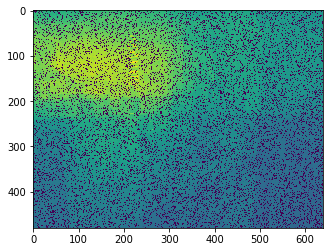

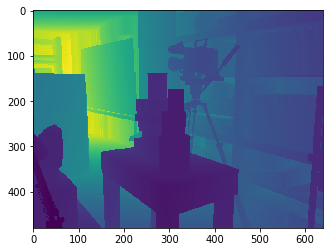

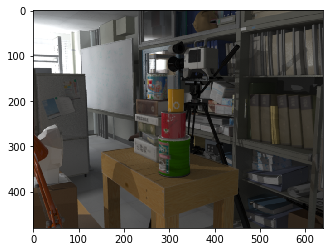

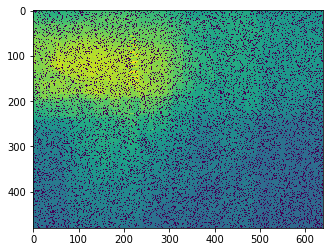

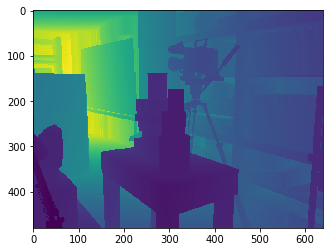

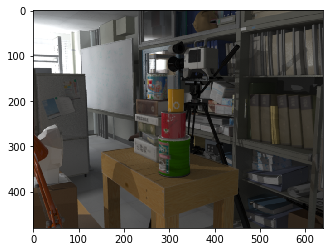

Loss: tensor(60070.9023, grad_fn=<MseLossBackward>)
Loss: tensor(71445.2344, grad_fn=<MseLossBackward>)
Loss: tensor(9084.9854, grad_fn=<MseLossBackward>)
Loss: tensor(29899.2988, grad_fn=<MseLossBackward>)
Loss: tensor(36521.4922, grad_fn=<MseLossBackward>)
Loss: tensor(35231.8750, grad_fn=<MseLossBackward>)
Loss: tensor(43479.4922, grad_fn=<MseLossBackward>)
Loss: tensor(32334.3633, grad_fn=<MseLossBackward>)
Loss: tensor(61470.7969, grad_fn=<MseLossBackward>)
Loss: tensor(31961.7344, grad_fn=<MseLossBackward>)
Loss: tensor(33608.7031, grad_fn=<MseLossBackward>)
Loss: tensor(51959.2266, grad_fn=<MseLossBackward>)
Loss: tensor(65048.9062, grad_fn=<MseLossBackward>)
Loss: tensor(18698.0742, grad_fn=<MseLossBackward>)
Loss: tensor(14796.8184, grad_fn=<MseLossBackward>)
Loss: tensor(14091.3887, grad_fn=<MseLossBackward>)
Loss: tensor(13829.6973, grad_fn=<MseLossBackward>)
Loss: tensor(14113.3359, grad_fn=<MseLossBackward>)
Loss: tensor(14520.2070, grad_fn=<MseLossBackward>)
Loss: tensor(

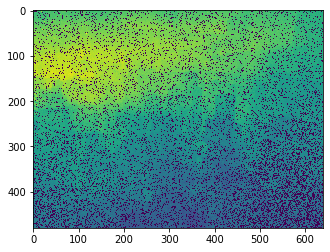

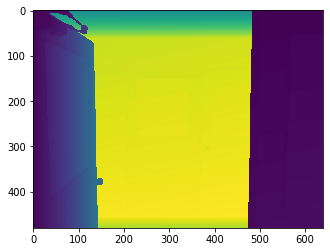

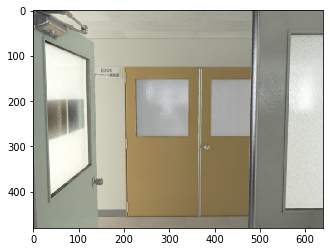

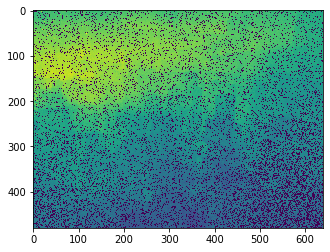

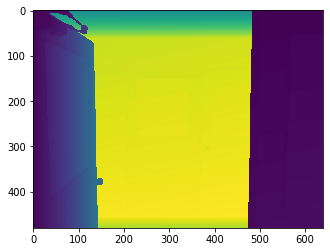

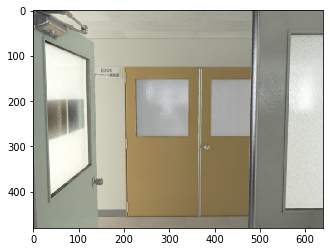

Loss: tensor(29529.3281, grad_fn=<MseLossBackward>)
Loss: tensor(114477.3203, grad_fn=<MseLossBackward>)
Loss: tensor(24639.0801, grad_fn=<MseLossBackward>)
Loss: tensor(30777.1035, grad_fn=<MseLossBackward>)
Loss: tensor(15564.8906, grad_fn=<MseLossBackward>)
Loss: tensor(50830.7227, grad_fn=<MseLossBackward>)
Loss: tensor(50436.7461, grad_fn=<MseLossBackward>)
Loss: tensor(11564.2295, grad_fn=<MseLossBackward>)
Loss: tensor(24501.0859, grad_fn=<MseLossBackward>)
Loss: tensor(59208.3164, grad_fn=<MseLossBackward>)
Loss: tensor(22368.3359, grad_fn=<MseLossBackward>)
Loss: tensor(11884.5371, grad_fn=<MseLossBackward>)
Loss: tensor(71686.0312, grad_fn=<MseLossBackward>)
Loss: tensor(34975.2617, grad_fn=<MseLossBackward>)
Loss: tensor(27194.6660, grad_fn=<MseLossBackward>)
Loss: tensor(101428.1719, grad_fn=<MseLossBackward>)
Loss: tensor(65410.9336, grad_fn=<MseLossBackward>)
Loss: tensor(50106.3867, grad_fn=<MseLossBackward>)
Loss: tensor(41578.5977, grad_fn=<MseLossBackward>)
Loss: tens

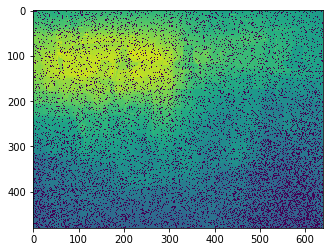

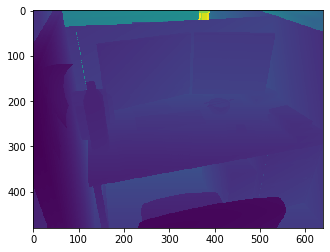

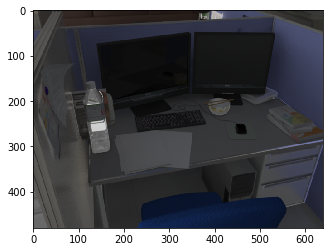

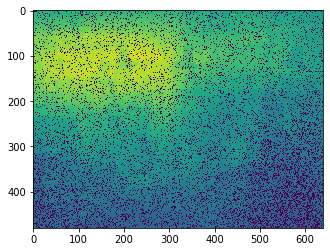

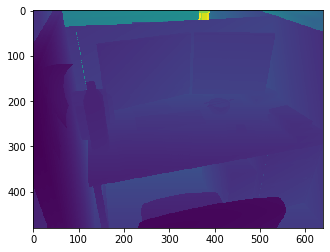

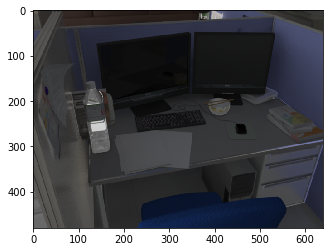

Loss: tensor(15254.0625, grad_fn=<MseLossBackward>)
Loss: tensor(33469.8672, grad_fn=<MseLossBackward>)
Loss: tensor(67168.6953, grad_fn=<MseLossBackward>)
Loss: tensor(31693.9160, grad_fn=<MseLossBackward>)
Loss: tensor(37949.1836, grad_fn=<MseLossBackward>)
Loss: tensor(23516.1367, grad_fn=<MseLossBackward>)
Loss: tensor(11048.7891, grad_fn=<MseLossBackward>)
Loss: tensor(16103.5527, grad_fn=<MseLossBackward>)
Loss: tensor(38074.3008, grad_fn=<MseLossBackward>)
Loss: tensor(13590.8613, grad_fn=<MseLossBackward>)
Loss: tensor(10921.7988, grad_fn=<MseLossBackward>)
Loss: tensor(56527.8906, grad_fn=<MseLossBackward>)
Loss: tensor(17303.4062, grad_fn=<MseLossBackward>)
Loss: tensor(65907.4375, grad_fn=<MseLossBackward>)
Loss: tensor(15051.9844, grad_fn=<MseLossBackward>)
Loss: tensor(26549.2129, grad_fn=<MseLossBackward>)
Loss: tensor(35306.5820, grad_fn=<MseLossBackward>)
Loss: tensor(45698.4688, grad_fn=<MseLossBackward>)
Loss: tensor(13514.7070, grad_fn=<MseLossBackward>)
Loss: tensor

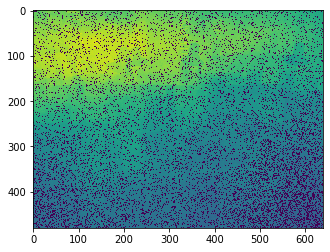

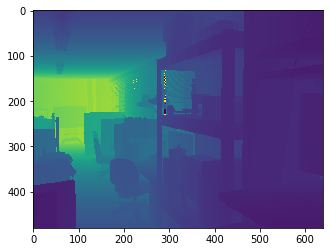

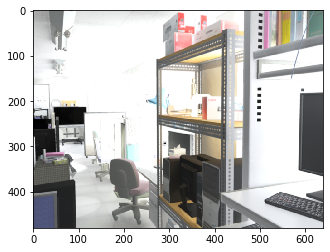

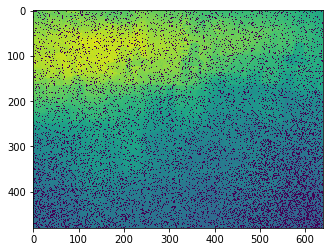

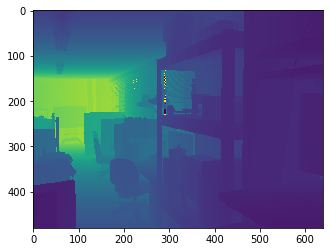

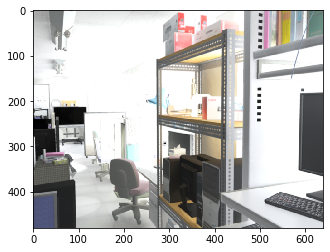

Loss: tensor(34402.4492, grad_fn=<MseLossBackward>)
Loss: tensor(15350.9932, grad_fn=<MseLossBackward>)
Loss: tensor(20121.9531, grad_fn=<MseLossBackward>)
Loss: tensor(16926.9727, grad_fn=<MseLossBackward>)
Loss: tensor(42526.6484, grad_fn=<MseLossBackward>)
Loss: tensor(10767.0713, grad_fn=<MseLossBackward>)
Loss: tensor(9570.7578, grad_fn=<MseLossBackward>)
Loss: tensor(64566.6211, grad_fn=<MseLossBackward>)
Loss: tensor(17429.4082, grad_fn=<MseLossBackward>)
Loss: tensor(7530.7622, grad_fn=<MseLossBackward>)
Loss: tensor(26466.4883, grad_fn=<MseLossBackward>)
Loss: tensor(16798.9785, grad_fn=<MseLossBackward>)
Loss: tensor(27922.5098, grad_fn=<MseLossBackward>)
Loss: tensor(81540.4531, grad_fn=<MseLossBackward>)
Loss: tensor(27175.6152, grad_fn=<MseLossBackward>)
Loss: tensor(73088.7656, grad_fn=<MseLossBackward>)
Loss: tensor(30734.7598, grad_fn=<MseLossBackward>)
Loss: tensor(15072.0352, grad_fn=<MseLossBackward>)
Loss: tensor(37355.1289, grad_fn=<MseLossBackward>)
Loss: tensor(1

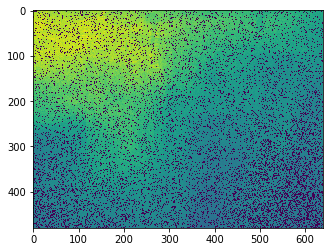

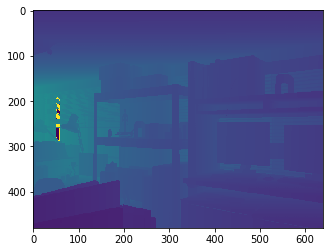

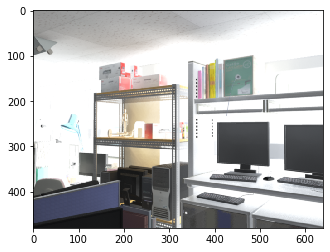

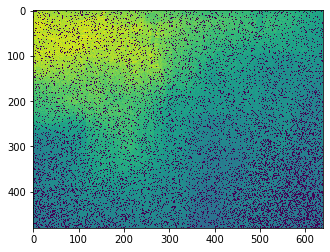

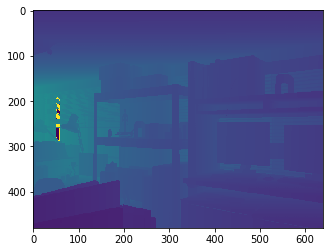

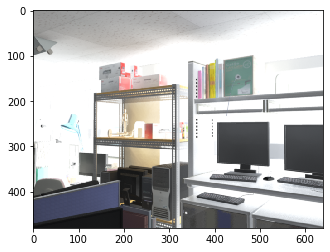

Loss: tensor(10073.5078, grad_fn=<MseLossBackward>)
Loss: tensor(56026.3711, grad_fn=<MseLossBackward>)
Loss: tensor(53064.7734, grad_fn=<MseLossBackward>)
Loss: tensor(5328.4033, grad_fn=<MseLossBackward>)
Loss: tensor(14083.9258, grad_fn=<MseLossBackward>)
Loss: tensor(44346.4648, grad_fn=<MseLossBackward>)
Loss: tensor(33844.4102, grad_fn=<MseLossBackward>)
Loss: tensor(82200.1641, grad_fn=<MseLossBackward>)
Loss: tensor(19315.4434, grad_fn=<MseLossBackward>)
Loss: tensor(25831.0098, grad_fn=<MseLossBackward>)
Loss: tensor(14295.3730, grad_fn=<MseLossBackward>)
Loss: tensor(39836.2383, grad_fn=<MseLossBackward>)
Loss: tensor(32893.4414, grad_fn=<MseLossBackward>)
Loss: tensor(11674.2188, grad_fn=<MseLossBackward>)
Loss: tensor(31225.2031, grad_fn=<MseLossBackward>)
Loss: tensor(29028.0039, grad_fn=<MseLossBackward>)
Loss: tensor(79811.1328, grad_fn=<MseLossBackward>)
Loss: tensor(22760.4688, grad_fn=<MseLossBackward>)
Loss: tensor(21402.3809, grad_fn=<MseLossBackward>)
Loss: tensor(

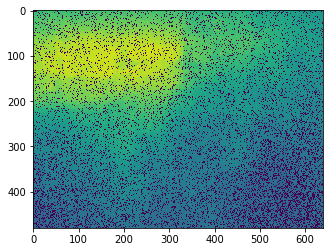

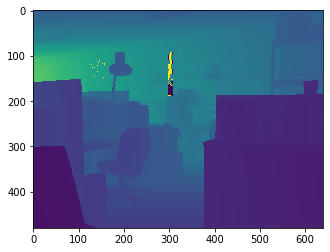

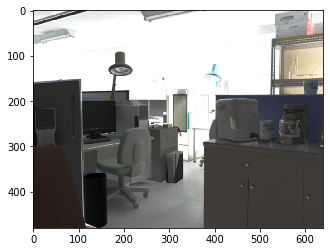

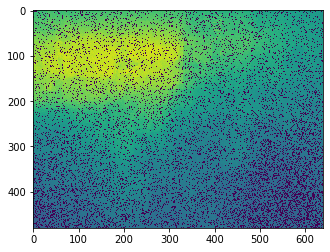

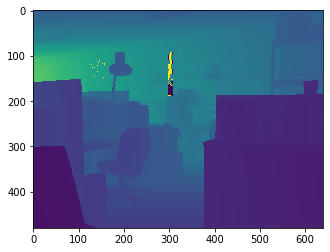

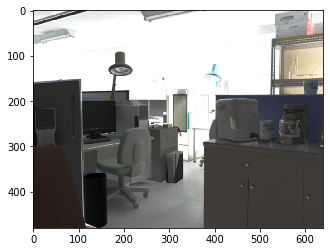

Loss: tensor(64229.1719, grad_fn=<MseLossBackward>)
Loss: tensor(27672.4531, grad_fn=<MseLossBackward>)
Loss: tensor(7319.6860, grad_fn=<MseLossBackward>)
Loss: tensor(23964.7344, grad_fn=<MseLossBackward>)
Loss: tensor(20511.1582, grad_fn=<MseLossBackward>)
Loss: tensor(43735.5469, grad_fn=<MseLossBackward>)
Loss: tensor(41861.0117, grad_fn=<MseLossBackward>)
Loss: tensor(30283.2617, grad_fn=<MseLossBackward>)
Loss: tensor(17880.8379, grad_fn=<MseLossBackward>)
Loss: tensor(72719.8906, grad_fn=<MseLossBackward>)
Loss: tensor(23410.2988, grad_fn=<MseLossBackward>)
Loss: tensor(21548.8242, grad_fn=<MseLossBackward>)
Loss: tensor(48244.1055, grad_fn=<MseLossBackward>)
Loss: tensor(38740.4141, grad_fn=<MseLossBackward>)
Loss: tensor(9207.8320, grad_fn=<MseLossBackward>)
Loss: tensor(29649.7051, grad_fn=<MseLossBackward>)
Loss: tensor(11215.6230, grad_fn=<MseLossBackward>)
Loss: tensor(22260.8867, grad_fn=<MseLossBackward>)
Loss: tensor(70376.9688, grad_fn=<MseLossBackward>)
Loss: tensor(1

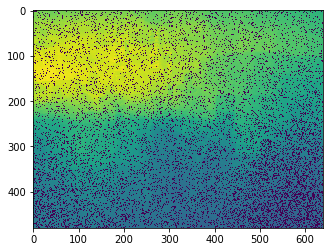

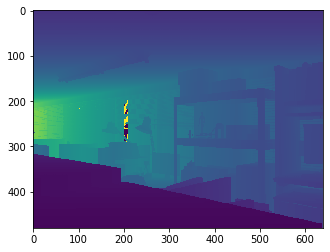

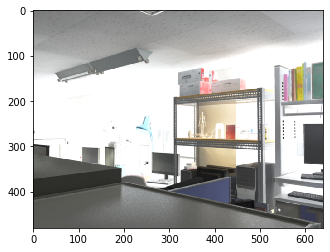

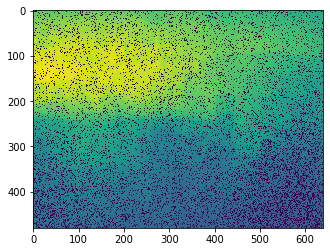

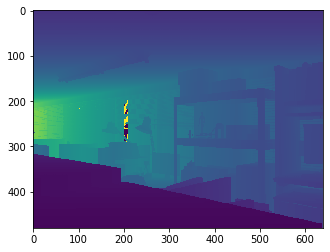

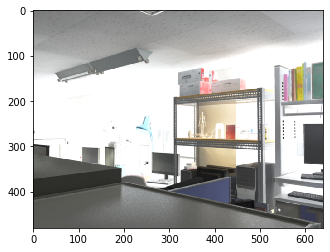

Loss: tensor(28523.5391, grad_fn=<MseLossBackward>)
Loss: tensor(9781.0176, grad_fn=<MseLossBackward>)
Loss: tensor(45280.3516, grad_fn=<MseLossBackward>)
Loss: tensor(46153.2578, grad_fn=<MseLossBackward>)
Loss: tensor(35671.3633, grad_fn=<MseLossBackward>)
Loss: tensor(28897.2910, grad_fn=<MseLossBackward>)
Loss: tensor(49033.2070, grad_fn=<MseLossBackward>)
Loss: tensor(12886.1797, grad_fn=<MseLossBackward>)
Loss: tensor(7644.2954, grad_fn=<MseLossBackward>)
Loss: tensor(9873.1377, grad_fn=<MseLossBackward>)
Loss: tensor(20007.9141, grad_fn=<MseLossBackward>)
Loss: tensor(30926.7656, grad_fn=<MseLossBackward>)
Loss: tensor(45419.1758, grad_fn=<MseLossBackward>)
Loss: tensor(33585.2383, grad_fn=<MseLossBackward>)
Loss: tensor(42061.3945, grad_fn=<MseLossBackward>)
Loss: tensor(41580.2891, grad_fn=<MseLossBackward>)
Loss: tensor(21602.6328, grad_fn=<MseLossBackward>)
Loss: tensor(33677.3867, grad_fn=<MseLossBackward>)
Loss: tensor(37474.8125, grad_fn=<MseLossBackward>)
Loss: tensor(38

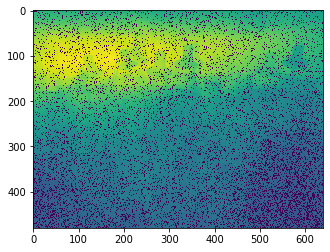

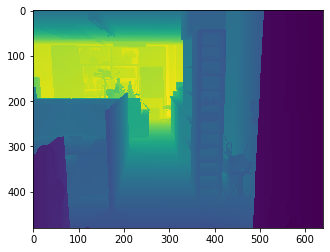

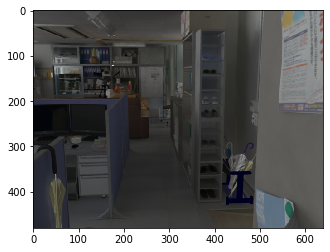

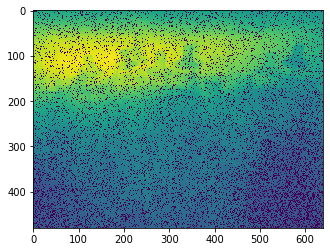

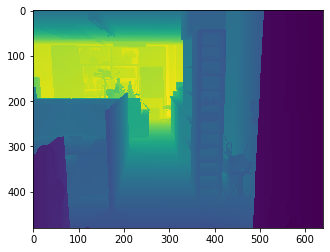

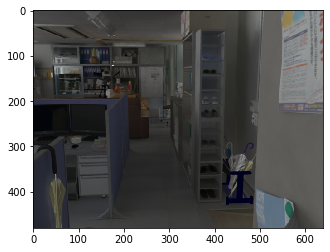

Loss: tensor(30335.6855, grad_fn=<MseLossBackward>)
Loss: tensor(29517.4121, grad_fn=<MseLossBackward>)
Loss: tensor(52555.6836, grad_fn=<MseLossBackward>)
Loss: tensor(28157.2051, grad_fn=<MseLossBackward>)
Loss: tensor(11124.2812, grad_fn=<MseLossBackward>)
Loss: tensor(46507.8398, grad_fn=<MseLossBackward>)
Loss: tensor(13072.4990, grad_fn=<MseLossBackward>)
Loss: tensor(49411.6055, grad_fn=<MseLossBackward>)
Loss: tensor(7067.6719, grad_fn=<MseLossBackward>)
Loss: tensor(30989.6602, grad_fn=<MseLossBackward>)
Loss: tensor(33371.1094, grad_fn=<MseLossBackward>)
Loss: tensor(34522.2539, grad_fn=<MseLossBackward>)
Loss: tensor(35165.1797, grad_fn=<MseLossBackward>)
Loss: tensor(7535.7061, grad_fn=<MseLossBackward>)
Loss: tensor(26044.1816, grad_fn=<MseLossBackward>)
Loss: tensor(16931.3066, grad_fn=<MseLossBackward>)
Loss: tensor(10723.9434, grad_fn=<MseLossBackward>)
Loss: tensor(41398.3945, grad_fn=<MseLossBackward>)
Loss: tensor(51457.6211, grad_fn=<MseLossBackward>)
Loss: tensor(2

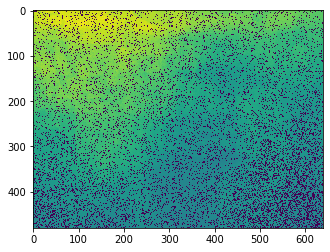

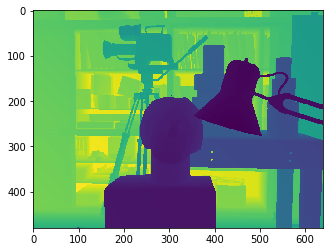

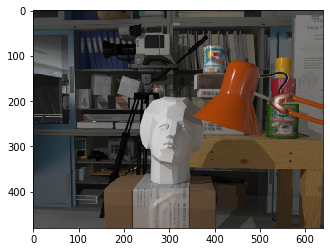

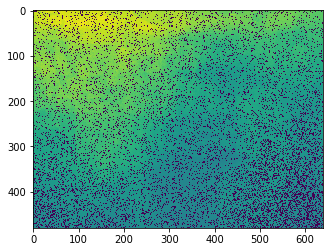

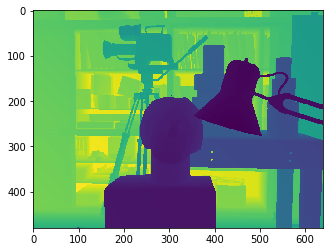

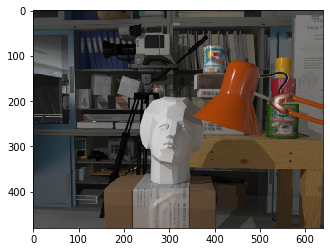

Loss: tensor(21685.5234, grad_fn=<MseLossBackward>)
Loss: tensor(14543.0938, grad_fn=<MseLossBackward>)
Loss: tensor(60353.0234, grad_fn=<MseLossBackward>)
Loss: tensor(12047.6836, grad_fn=<MseLossBackward>)
Loss: tensor(9830.8760, grad_fn=<MseLossBackward>)
Loss: tensor(26068.0039, grad_fn=<MseLossBackward>)
Loss: tensor(11186.4629, grad_fn=<MseLossBackward>)
Loss: tensor(45532.2031, grad_fn=<MseLossBackward>)
Loss: tensor(7189.6118, grad_fn=<MseLossBackward>)
Loss: tensor(15755.3203, grad_fn=<MseLossBackward>)
Loss: tensor(62004.7461, grad_fn=<MseLossBackward>)
Loss: tensor(6945.5254, grad_fn=<MseLossBackward>)
Loss: tensor(64448.1406, grad_fn=<MseLossBackward>)
Loss: tensor(19411.7461, grad_fn=<MseLossBackward>)
Loss: tensor(44154.8477, grad_fn=<MseLossBackward>)
Loss: tensor(49534.1250, grad_fn=<MseLossBackward>)
Loss: tensor(21410.5039, grad_fn=<MseLossBackward>)
Loss: tensor(28095.2109, grad_fn=<MseLossBackward>)
Loss: tensor(15909.2988, grad_fn=<MseLossBackward>)
Loss: tensor(11

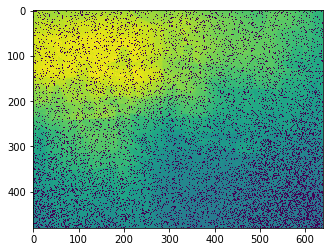

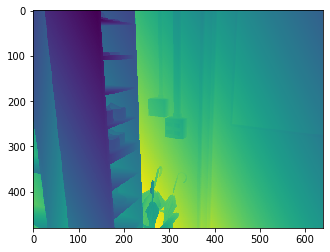

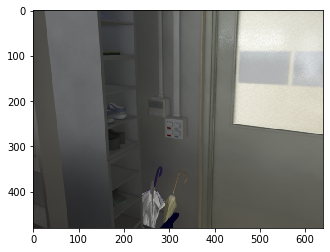

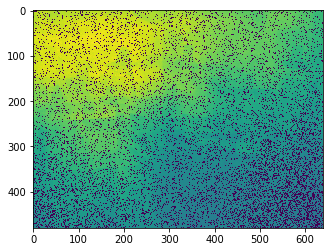

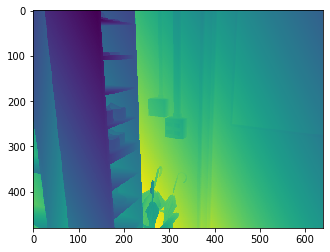

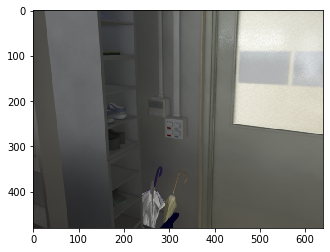

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type SiameseNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3

In [207]:
def main():
    height = 480
    width = 640
    net = SiameseNetwork()
    #This will import the real dataset in tensor arrays once the data is available
    training_DATA_LEFT = np.load('test_daylight_left.npy')
    training_DATA_RIGHT = np.load('test_daylight_right.npy')
    depthMaps = np.load('test_depthmap_left.npy')
    # depthMaps = normalize(depthMaps)
    # training_DATA_LEFT = np.swapaxes(training_DATA_LEFT,1,3)
    # training_DATA_RIGHT = np.swapaxes(training_DATA_RIGHT,1,3)
    training_DATA_LEFT = torch.from_numpy(training_DATA_LEFT)
    training_DATA_RIGHT = torch.from_numpy(training_DATA_RIGHT)
    depthMaps = torch.from_numpy(depthMaps)
    # reshape output
    depthMaps = depthMaps.view(-1,width*height,1,1)
    network = final = train(net, training_DATA_LEFT, training_DATA_RIGHT, depthMaps, EPOCHS = 15, BATCH_SIZE = 5)
    torch.save(network, 'saved_network')

if __name__ == '__main__':
    main()

In [23]:
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
!ls "/content/drive/My Drive"

'ACML reinforcement learning.gdoc'
'ACML Report 1: Neural Network Lab.gdoc'
'Astronomy - Cosmology.gslides'
 Backup
'Colab Notebooks'
'Copy of lhcb_project_sarkosos_hollyqui.gdoc'
'Copy of Particle Identification and Machine Learning (1).gdoc'
'Copy of Particle Identification and Machine Learning.gdoc'
'Copy of PRO3000-Bebop2  Animal Tracking - Lab Report.gdoc'
'Copy of Project Paper.gdoc'
'debate analysis.docx'
'Facharbeit Felix Quinque final (1).gdoc'
'Final Presentation CaCD [Autosaved].pptx'
 Images
'Intelligent Systems.gslides'
'Intelligent Systems Report.gdoc'
 lhcb_project_sarkosos_hollyqui.gdoc
 MSP
'Personal Statement.gdoc'
'Photos 2019'
'pid_presentation correction.gslides'
 pid_presentation_edited.gslides
 programming
'Sample test data'
'SLP supervisor information form_Jan 2020.gdoc'
'Songs I can Sing.gdoc'
 Stereovision
'tisc report.gdoc'
'Untitled document.gdoc'
'Untitled site.gsite'
'Vibrations and Waves Script.gdoc'
'VibWav video.gdoc'
 videos
 Whatsapp
'WhatsApp Chat wi

In [0]:
!cp "/content/drive/My Drive/Sample test data/test_daylight_left.npy" "test_daylight_left.npy"
!cp "/content/drive/My Drive/Sample test data/test_daylight_right.npy" "test_daylight_right.npy"
!cp "/content/drive/My Drive/Sample test data/test_depthmap_left.npy" "test_depthmap_left.npy"

torch.Size([180, 480, 640, 3])


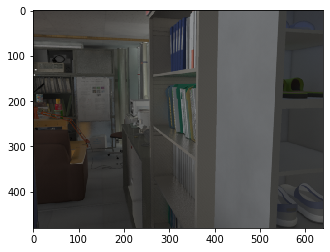

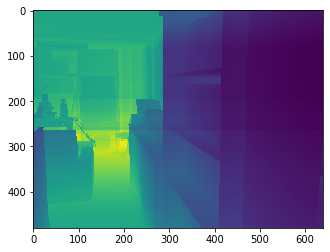

In [164]:
 #This will import the real dataset in tensor arrays once the data is available
training_DATA_LEFT = np.load('test_daylight_left.npy')
training_DATA_RIGHT = np.load('test_daylight_right.npy')
depthMaps = np.load('test_depthmap_left.npy')
depthMaps = normalize(depthMaps)
# training_DATA_LEFT = np.swapaxes(training_DATA_LEFT,1,3)
training_DATA_RIGHT = np.swapaxes(training_DATA_RIGHT,1,3)
training_DATA_RIGHT = np.swapaxes(training_DATA_RIGHT,1,2)

training_DATA_LEFT = torch.from_numpy(training_DATA_LEFT)
training_DATA_RIGHT = torch.from_numpy(training_DATA_RIGHT)
depthMaps = torch.from_numpy(depthMaps)

print(training_DATA_RIGHT.shape)
# reshape output
# depthMaps = depthMaps.view(-1,width*height,1,1)
plt.figure()
plt.imshow((training_DATA_RIGHT[126].detach().numpy()))
plt.show()
plt.figure()
plt.imshow(depthMaps[126].detach().numpy())
plt.show()